In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, time

plt.rcParams['figure.figsize'] = (15,15)
plt.rcParams.update({'font.size': 12})

# modifiable parameters
TEST_TASK_1 = True

# ** Task 1 modifiable parameters, if enabled
TASK_1_DIRECTORY = 'DataSamples'
TASK_1_IMAGE = 's3.jpg' # 's1' to 's5'

# ** Task 2 modifiable parameters, if enabled
TASK_2_DIRECTORY = 'high_qual_images'
TASK_2_IMAGE = '00911u.jpg' # '00549u', '00911u'

TASK_2_ATTEMPTS = 10  # num iterations (downsampling factors) to attempt
TASK_2_RUNTIME_SECONDS_THRESHOLD = 1  # tolerable num seconds taken by cur loop before we terminate after this loop

### Task 1

Ctrl+F for `[MODIFIABLE PARAM]` for modifiable parameters (e.g. what file to open).

In [78]:
# From Lab 1, Question 2.2
# https://theailearner.com/2019/04/10/histogram-matching-specification/

# Source: https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x
# Note: function only logically works for greyscale / 1-channel at a time
# (asked tutor - this method is too good for Lab 1)
def histMatch(source, template):
    pixel_type = type(source[0][0])
    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()
    # * (can be later reshaped to 2D image if pixel order does not change)

    # get the set of unique pixel values and their corresponding 
    # indices and counts (better than doing a histogram as this tells
    # you where the pixels are located)
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)
    # * (return_inverse) --> returns indices for that unique value
    #      --> you can reconstruct ar from all the collected indices
    # * (only need to match indexes of src image to template's histogram)
    
    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    # * (cumsum just does a sums of: cur_val + prev_vals, per iteration)
    # * (i.e. from lecture slides, nk(s_counts) / MN(total_pixels))
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)
    interp_t_values = interp_t_values.astype(pixel_type)
    # * (vals in a 3 channel greyscale img are triple-counted; seems safe)

    return interp_t_values[bin_idx].reshape(oldshape) # cast back to 2D img

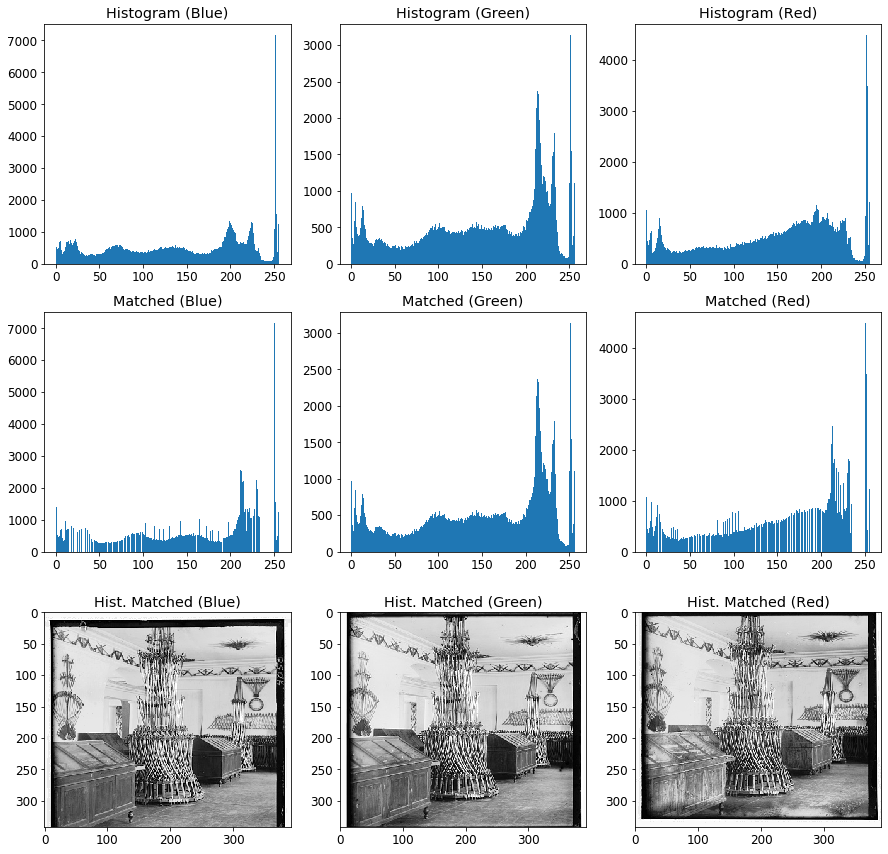

In [79]:
# reads image, partitions it into three sub-images. assumed image structure (b,g,r) descending
def getImageComponents(fp):
    img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
    nrows = img.shape[0]
    height = int(np.ceil(nrows/3))
    g_start = int(np.round((nrows - height)/2))
    # split img into thirds
    b = img[:height, :]
    g = img[g_start:g_start+height, :]
    r = img[-height:, :]
    return b,g,r

height = lambda img : img.shape[0]
width = lambda img : img.shape[1]

# https://robotacademy.net.au/lesson/template-matching/
#####################################################
# METRICS
def _ssdMetric(A,B): # sum of squared differences
    return ((A-B)**2).sum()

def _ssdBestValue(metric_result):
    best_index = np.unravel_index(np.argmin(metric_result, axis=None), metric_result.shape)
    return best_index # corresponds to img offset
    
def _sadMetric(A,B): # sum of absolute differences
    return (abs(A-B)).sum()

def _sadBestValue(metric_result):
    return _ssdBestValue(metric_result) # get min
    
# https://stackoverflow.com/questions/15215310/special-situation-in-normalized-cross-correlation-for-template-matching
def _nccMetric(A,B): # normalised cross-correlation
    return (A*B).sum() / np.sqrt((A**2).sum() * (B**2).sum())  # maybe wrong? div by 0 sometimes

# https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)
def _nccMetric(A,B, meanA,stdA, meanB,stdB):
    components = (A - meanA) * (B - meanB) / (stdA * stdB)
    return components.sum() / (A.size + B.size)  # likely v. slow

def _nccBestValue(metric_result): # correlation == 1, gives perfect match
    best_index = np.unravel_index(np.argmax(metric_result, axis=None), metric_result.shape)
    return best_index
    
#####################################################
# comparison logic: doesn't work as expected. Why?
# TM_SQDIFF, TM_SQDIFF_NORMED, TM_CCORR, TM_CCORR_NORMED, TM_CCOEFF, TM_CCOEFF_NORMED
def _matchTemplateCv2(mt_img, mt_template, cv_method=cv2.TM_SQDIFF_NORMED):
    mt_result = cv2.matchTemplate(mt_img, mt_template, cv_method)
    _, _, mt_locmin, mt_locmax = cv2.minMaxLoc(mt_result)
    if cv_method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        mt_start = mt_locmin
    else:
        mt_start = mt_locmax
    #mt_stop  = (mt_start[0]+width(mt_img), mt_start[1]+height(mt_img))
    return mt_start #, mt_stop # (top left, bot right) each in (r,c) format


# img is searched through all possible offsets of a padded temp(late)
def _matchTemplate(img, temp):
    # find range in which img can sweep across (padded) template
    img_nr, img_nc = img.shape
    temp_nr, temp_nc = temp.shape
    maxshift_r = temp_nr - img_nr
    maxshift_c = temp_nc - img_nc
    
    #img_mean, img_std = cv2.meanStdDev(img)     # used for zncc, if used  [MODIFIABLE PARAM]
    #temp_mean, temp_std = cv2.meanStdDev(temp)
    
    metric_result = np.zeros((maxshift_r +1, maxshift_c +1))
    for r in range(maxshift_r +1):
        for c in range(maxshift_c +1):
            # construct window from template (same size as img)
            temp_window = temp[r : r + img_nr, c : c + img_nc]
            
            # compute similarity metric                          # <--[MODIFIABLE PARAM]
            metric_result[r,c] = _ssdMetric(img, temp_window)
            #metric_result[r,c] = _nccMetric(img, temp_window, img_mean,img_std, temp_mean,temp_std)
            
            #print("mt: off({},{}): imgsize={} (tempsize={}); res={}".format(r,c,img.shape,temp.shape,metric_result[r,c]))
    
    # choose optimal similarity result                           # <--[MODIFIABLE PARAM]
    offset_r, offset_c = _ssdBestValue(metric_result)
    
    return offset_r, offset_c
    
    
# generates a padded version of the image (with the same shape as the temp(late)),
# with the computed offset applied to it
def _getOffsetImage(img, temp, offset_r, offset_c):
    img_nr, img_nc = img.shape
    # generate offsetted image
    new_img = np.zeros(temp.shape, dtype=type(temp[0,0]))
    new_img[offset_r : (offset_r + img_nr), offset_c : (offset_c + img_nc)] = img
    return new_img


# convenience function to set up calls to:   _matchTemplate()
# returns:
#  * b_offsets(r,c): offset that needs to be applied to img 'b' to align with 'g_new'
#  * g_new: 'g' with a zero-padded border on all sides
#  * r_offsets(r,c): same as b_offsets, but for 'r'
#  * borders(r,c): border (width,length) applied to EACH edge of 'g'
def alignComponents(b,g,r):
    # assume g == template (most accurately sliced)
    divisor = 16   # original method used: divisor=2
    bord_r = max(int(g.shape[0]/divisor), 10)
    bord_c = max(int(g.shape[1]/divisor), 10)
    g_new = cv2.copyMakeBorder(g, bord_r, bord_r, bord_c, bord_c, cv2.BORDER_CONSTANT)#, value=255)
    print("Border: nrow={}, ncol={}".format(bord_r, bord_c))
    
    # compare: r,b <--> g (template)
    r_time = time.time()
    print("Running mt() on (r,g)")
    r_offset_row, r_offset_col = _matchTemplate(r, g_new)   # <--[MODIFIABLE PARAM]
    print(" * [Done]: took {} seconds.".format(time.time() - r_time))
    
    b_time = time.time()
    print("Running mt() on (b,g)")
    b_offset_row, b_offset_col = _matchTemplate(b, g_new)   # <--[MODIFIABLE PARAM]
    print(" * [Done]: took {} seconds.".format(time.time() - b_time))
    return (b_offset_row, b_offset_col), g_new, (r_offset_row, r_offset_col), (bord_r, bord_c)
    
# (hacked off this subfunction from alignComponents() to allow for histogram matching injection)
# convenience function to set up calls to:   _getOffsetImage()
def applyAlignment(b,g_new,r, b_offsets,r_offsets):
    r_offset_row, r_offset_col = r_offsets
    b_offset_row, b_offset_col = b_offsets
    
    print("Red  offset: row={}, col={}".format(r_offset_row, r_offset_col))
    print("Blue offset: row={}, col={}".format(b_offset_row, b_offset_col))
    r_new = _getOffsetImage(r, g_new, r_offset_row, r_offset_col)
    b_new = _getOffsetImage(b, g_new, b_offset_row, b_offset_col)
    
    return b_new, r_new

# computes the RoI to remove the border from the padded result of 'g'
def getCropAlignmentOrig(borders,g): # cut back to size 'g'
    img_nr, img_nc = g.shape
    bord_r, bord_c = borders
    #crop = lambda bigimg : bigimg[ bord_r:bord_r+img_nr , bord_c:bord_c+img_nc ]
    return bord_r,bord_r+img_nr , bord_c,bord_c+img_nc

# reduce overall img size to remove colored bars --> performs poorly
def getCropAlignment(borders,g, b_offset, r_offset):  # all args in (r,c)
    img_nr, img_nc = g.shape
    def getValues(i):
        i_start = max(borders[i],b_offset[i],r_offset[i])
        i_diff = max(abs(borders[i]-b_offset[i]), abs(borders[i]-r_offset[i]), abs(b_offset[i]-r_offset[i]))
        i_length = img_nr - i_diff
        i_stop = i_start+i_length
        return i_start, i_stop
    
    row_start, row_stop = getValues(0)
    col_start, col_stop = getValues(1)
    return row_start,row_stop, col_start,col_stop


#####################################################
# get image components
if TEST_TASK_1:
    fp = os.path.join(TASK_1_DIRECTORY, TASK_1_IMAGE)           # <--[MODIFIABLE PARAM]
    b,g,r = getImageComponents(fp)

    # apply histogram matching
    nr = 3
    nc = 3
    label_comps = ['Blue', 'Green', 'Red']
    img_comps = [b,g,r]
    for i in range(3):
        plt.subplot(nr,nc,i+1)
        plt.title('Histogram ({})'.format(label_comps[i]))
        plt.hist(img_comps[i].ravel(), 256, [0,256])

        b_mh = histMatch(b, g)
        r_mh = histMatch(r, g)

    img_comps = [b_mh,g,r_mh]
    for i in range(3):
        plt.subplot(nr,nc,i+4)
        plt.title('Matched ({})'.format(label_comps[i]))
        plt.hist(img_comps[i].ravel(), 256, [0,256])
        plt.subplot(nr,nc,i+7)
        plt.title('Hist. Matched ({})'.format(label_comps[i]))
        plt.imshow(img_comps[i], cmap=plt.get_cmap('gray'))

    #b = b_mh # test only
    #r = r_mh    

Border: nrow=21, ncol=24
Running mt() on (r,g)
 * [Done]: took 0.5949156284332275 seconds.
Running mt() on (b,g)
 * [Done]: took 0.6921517848968506 seconds.
Red  offset: row=28, col=24
Blue offset: row=14, col=22


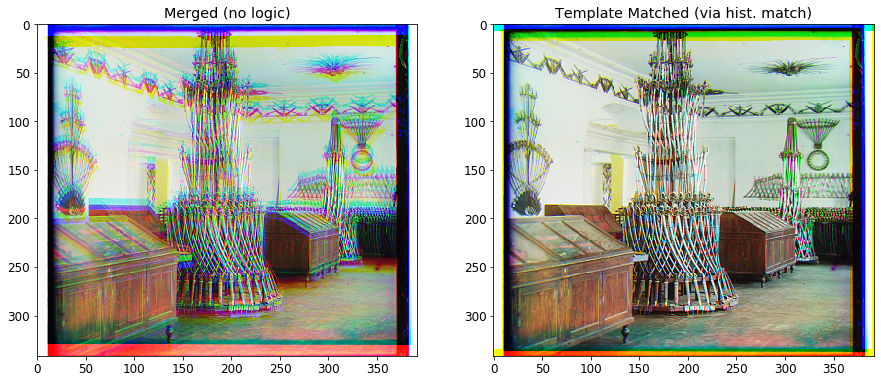

In [80]:
# RESULTS: generate & plot aligned image
if TEST_TASK_1:
    original_img = cv2.merge((b,g,r))

    b_offset, g_new, r_offset, borders = alignComponents(b_mh, g, r_mh)
    b_new, r_new = applyAlignment(b,g_new,r, b_offset,r_offset)

    #aligned_img = cv2.merge((b_new,g_new,r_new))       # <--[MODIFIABLE PARAM]; view padding
    row_start,row_stop, col_start,col_stop = getCropAlignmentOrig(borders, g)
    #row_start,row_stop, col_start,col_stop = getCropAlignment(borders, g, b_offset, r_offset)
    aligned_img = cv2.merge((b_new,g_new,r_new))[row_start:row_stop, col_start:col_stop, :]

    nr = 1
    nc = 2
    plt.subplot(nr,nc,1)
    plt.title("Merged (no logic)")
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.subplot(nr,nc,2)
    plt.title("Template Matched (via hist. match)")
    plt.imshow(cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB))

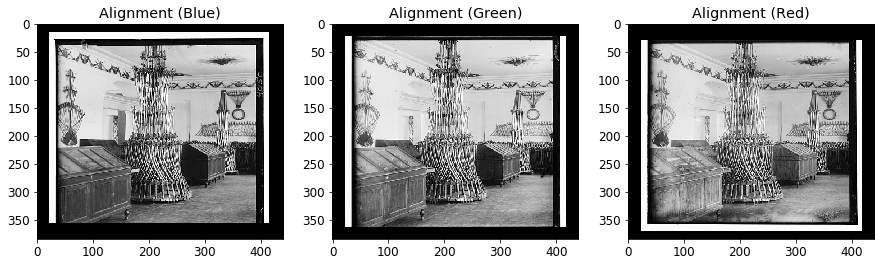

In [81]:
# RESULTS: plot subcomponents of aligned image
if TEST_TASK_1:
    nr = 1
    nc = 3
    plt.subplot(nr,nc,1)
    plt.title("Alignment (Blue)")
    plt.imshow(b_new, cmap=plt.get_cmap('gray'))
    plt.subplot(nr,nc,2)
    plt.title("Alignment (Green)")
    plt.imshow(g_new, cmap=plt.get_cmap('gray'))
    plt.subplot(nr,nc,3)
    plt.title("Alignment (Red)")
    plt.imshow(r_new, cmap=plt.get_cmap('gray'))

### Task 2


[LOOP 0]: Running for downfactor: 512
Border: nrow=10, ncol=10
Running mt() on (r,g)
 * [Done]: took 0.002991199493408203 seconds.
Running mt() on (b,g)
 * [Done]: took 0.002991914749145508 seconds.
Red  offset: row=5183, col=6000
Blue offset: row=5183, col=6000
 * Total runtime: 0.467071533203125 seconds

[LOOP 1]: Running for downfactor: 256
Border: nrow=10, ncol=10
Running mt() on (r,g)
 * [Done]: took 0.002992868423461914 seconds.
Running mt() on (b,g)
 * [Done]: took 0.003989219665527344 seconds.
Red  offset: row=2591, col=2571
Blue offset: row=2591, col=2571
 * Total runtime: 0.19248461723327637 seconds

[LOOP 2]: Running for downfactor: 128
Border: nrow=10, ncol=10
Running mt() on (r,g)
 * [Done]: took 0.0029921531677246094 seconds.
Running mt() on (b,g)
 * [Done]: took 0.0029921531677246094 seconds.
Red  offset: row=1295, col=1285
Blue offset: row=1295, col=1285
 * Total runtime: 0.06781816482543945 seconds

[LOOP 3]: Running for downfactor: 64
Border: nrow=10, ncol=10
Running

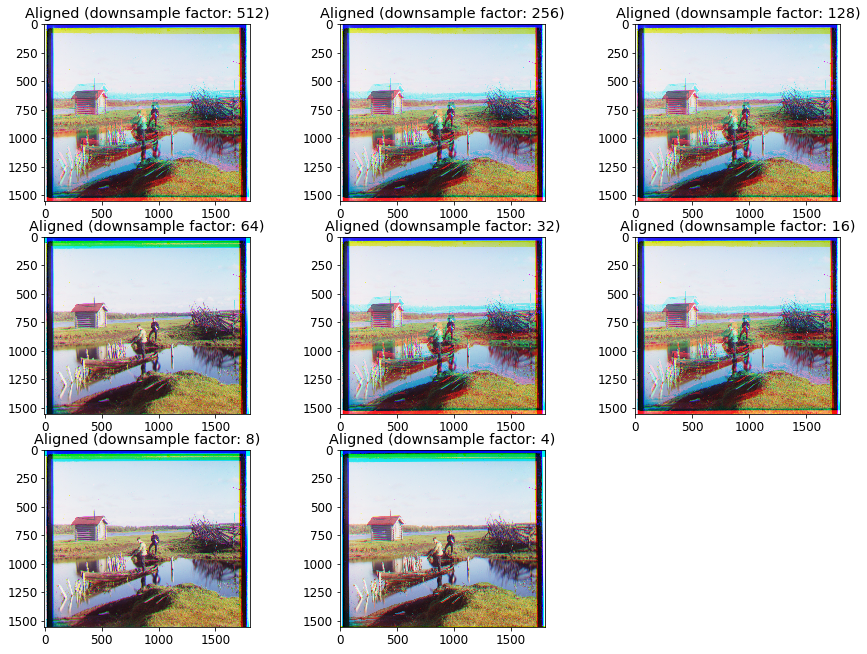

In [82]:
# wrapper for: alignComponents(b_mh, g, r_mh)
def pyramidAlignComponents(b,g,r,downscale_factor):
    # downscale images (assumes all 3 are identical sizes)
    img_nr,img_nc = g.shape
    new_nr = int(img_nr/downscale_factor)
    new_nc = int(img_nc/downscale_factor)
    if new_nr < 1 or new_nc < 1:
        raise AssertionError("Factor is too small to down-sample image to this resolution")
    
    new_b = cv2.resize(b, (new_nr, new_nc))
    new_g = cv2.resize(g, (new_nr, new_nc))
    new_r = cv2.resize(r, (new_nr, new_nc))
    
    # apply image alignment
    b_offsets, _, r_offsets, border = alignComponents(new_b, new_g, new_r)
    
    # upscale received offset values (may have rounding error)
    upscale_r = img_nr/new_nr
    upscale_c = img_nc/new_nc 
    def upscale_offsets(dr,dc): 
        return (int(dr * upscale_r), int(dc * upscale_c))
    
    b_offsets = upscale_offsets(b_offsets[0],b_offsets[1])
    r_offsets = upscale_offsets(r_offsets[0],r_offsets[1])
    
    # ** reapply border to regenerate 'new_g'
    border = upscale_offsets(border[0],border[1])
    bord_r, bord_c = border
    g_bordered = cv2.copyMakeBorder(g, bord_r, bord_r, bord_c, bord_c, cv2.BORDER_CONSTANT)
    
    return b_offsets, g_bordered, r_offsets, border
    
    
#####################################################
# RESULTS: generate and plot for high resolution image

# get image components 
fp = os.path.join(TASK_2_DIRECTORY, TASK_2_IMAGE)    # <--[MODIFIABLE PARAM]
b,g,r = getImageComponents(fp)
original_img = cv2.merge((b,g,r))

# get histogram matched components
b_mh = histMatch(b, g)
r_mh = histMatch(r, g)

# perform image alignment
def getPyramidAlignedImage(b,g,r, b_mh,r_mh, downfactor):
    b_offset, g_new, r_offset, borders = pyramidAlignComponents(b_mh, g, r_mh, downfactor)
    b_new, r_new = applyAlignment(b,g_new,r, b_offset,r_offset)

    #aligned_img = cv2.merge((b_new,g_new,r_new))       # <--[MODIFIABLE PARAM]
    row_start,row_stop, col_start,col_stop = getCropAlignmentOrig(borders, g)
    aligned_img = cv2.merge((b_new,g_new,r_new))[row_start:row_stop, col_start:col_stop, :]
    return aligned_img

# ** image alignment loop (for comparison purposes)
nc = 3
nr = int(np.ceil(TASK_2_ATTEMPTS/nc))

for i in range(TASK_2_ATTEMPTS):
    downfactor = 2**(TASK_2_ATTEMPTS-1-i)
    print("\n[LOOP {}]: Running for downfactor: {}".format(i, downfactor))
    plt.subplot(nr,nc,i+1)
    try:
        start = time.time()
        aligned_img = getPyramidAlignedImage(b,g,r, b_mh,r_mh, downfactor)
        end = time.time()
        print(" * Total runtime: {} seconds".format(end-start))
        plt.title("Aligned (downsample factor: {})".format(downfactor))
        plt.imshow(cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB))
        
        if (end-start) >= TASK_2_RUNTIME_SECONDS_THRESHOLD:
            print("Stopping as subsequent runs will take too long.")
            break
    except AssertionError as e:
        print("Invalid downsampling factor; trying next value")
        continue  
        #print("Stopping:", e)
        #break


### Task 3